In [1]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from textblob import Word
import textblob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
#load data
data = pd.read_csv("tweet_emotions.csv", ',')

/tmp/ipykernel_29128/2118856244.py:2: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data = pd.read_csv("tweet_emotions.csv", ',')


## Exploratory Data Analysis

In [3]:
# Convert to dataframe
data.shape

(40000, 3)

In [4]:
data.empty

False

In [5]:
# Drop the tweet_id column
data = data[['sentiment', 'content']]
data.head

<bound method NDFrame.head of         sentiment                                            content
0           empty  @tiffanylue i know  i was listenin to bad habi...
1         sadness  Layin n bed with a headache  ughhhh...waitin o...
2         sadness                Funeral ceremony...gloomy friday...
3      enthusiasm               wants to hang out with friends SOON!
4         neutral  @dannycastillo We want to trade with someone w...
...           ...                                                ...
39995     neutral                                   @JohnLloydTaylor
39996        love                     Happy Mothers Day  All my love
39997        love  Happy Mother's Day to all the mommies out ther...
39998   happiness  @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999        love  @mopedronin bullet train from tokyo    the gf ...

[40000 rows x 2 columns]>

In [6]:
data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

<AxesSubplot: xlabel='sentiment'>

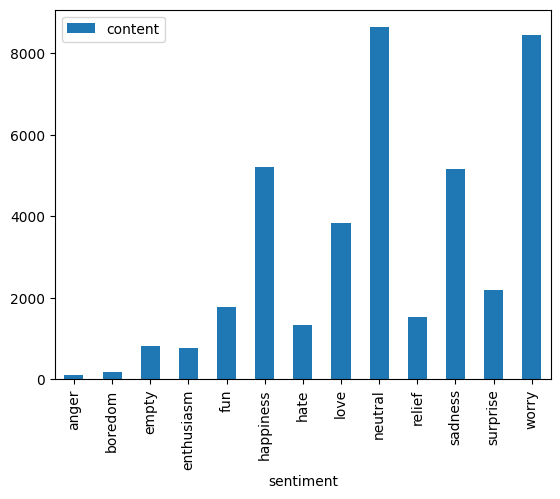

In [7]:
# Distribution of tweets per category
data_eda = data.groupby(['sentiment']).count()
data_eda.plot.bar()

In [8]:
data_eda['percentage'] = (data_eda['content']/ data_eda['content'].sum()) * 100
print(data_eda)

            content  percentage
sentiment                      
anger           110      0.2750
boredom         179      0.4475
empty           827      2.0675
enthusiasm      759      1.8975
fun            1776      4.4400
happiness      5209     13.0225
hate           1323      3.3075
love           3842      9.6050
neutral        8638     21.5950
relief         1526      3.8150
sadness        5165     12.9125
surprise       2187      5.4675
worry          8459     21.1475


## Preprocessing

In [9]:
# Download the stopwords dataset from NLTK library
!python -m textblob.download_corpora
nltk.download('stopwords')

[nltk_data] Downloading package brown to /home/fiona/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/fiona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fiona/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fiona/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/fiona/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/fiona/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


[nltk_data] Downloading package stopwords to /home/fiona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
STOPWORDS = stopwords.words("english")

In [11]:
# Function to text clean.
def clean(text):
    text = text.lower()
    text = re.sub("[^\w\s]", " ", text) # Remove punctuations
    text= re.sub(" +", " ", text) # Remove extra spaces
    text =  " ".join(w for w in text.split() if w not in STOPWORDS) # Remove stopwords
    text = " ".join([Word(word).lemmatize() for word in text.split()])
    return text

In [12]:
# Function to remove duplicates.
def remove_duplicate(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [13]:
# Call data cleaning functions.
data['text'] = data['content'].apply(lambda x: clean(x))
data['text'] = data['text'].apply(lambda x: remove_duplicate(x))
data.head()

,sentiment,content,text
0,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughh waitin call
2,sadness,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,neutral,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone houston ticke...


In [14]:
freq = pd.Series(" ".join(data['text']).split()).value_counts()[-10000:]
freq = list(freq.index)
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data.head()

,sentiment,content,text
0,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughh waitin call
2,sadness,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,neutral,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone houston ticke...


<AxesSubplot: >

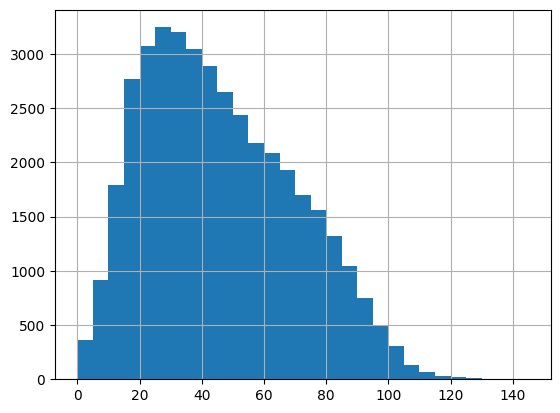

In [15]:
lens = data.text.str.len()
lens.hist(bins = np.arange(0,150,5))

In [39]:
data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [16]:
x = np.array(data['text'].values)
y =  np.array(data['sentiment'].values)

In [17]:
# Normalize the outcome of the dataset to numerical values
Le = LabelEncoder()
y =  Le.fit_transform(y)

In [18]:
# Split the dataset to training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=
                                                    True, random_state=242, stratify=y)

In [19]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(28000,)
(12000,)
(28000,)
(12000,)


In [20]:
x_train

array(['lucymeez tried pincode say expired put',
       'quot quot haha kinda make sad though http bit ly',
       'ah thats better snow patrol stuck indoors still weekend coming fresh air excellent hope sunny',
       ..., 'christian792 lol twitter addict',
       'sleep time lot last minute revision tomoro exam monday night tweet er lt 3',
       'mileycyrus oh voting worry already voted 100 time earlier'],
      dtype=object)

In [21]:
y

array([ 2, 10, 10, ...,  7,  5,  7])

In [22]:
# Convert tweets to number formart usinf TFID.
tf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,3))
x_tf = tf.fit_transform(x_train)
x_val_tf = tf.transform(x_test)

In [23]:
x_tf

<28000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 139964 stored elements in Compressed Sparse Row format>

## Modeling

In [24]:
# Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(x_tf, y_train)

MultinomialNB()

In [25]:
prediction = model.predict(x_val_tf)

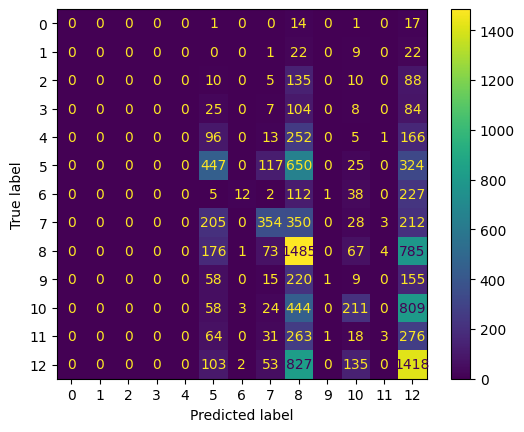

In [26]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [27]:
accuracy_score(y_test, prediction)

0.32758333333333334

In [28]:
f1_score(y_test, prediction, average='weighted')

0.2766635500714163

In [29]:
# Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1)
model.fit(x_tf, y_train)

LogisticRegression(C=1, solver='liblinear')

In [30]:
prediction = model.predict(x_val_tf)

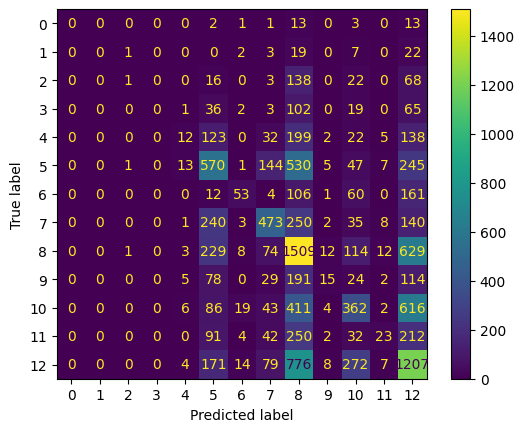

In [31]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [32]:
accuracy_score(y_test, prediction)

0.35208333333333336

In [33]:
f1_score(y_test, prediction, average='weighted')

0.3156172261137119

In [34]:
# Random Forest Classifier
model = RandomForestClassifier()
model.fit(x_tf, y_train)

RandomForestClassifier()

In [35]:
prediction = model.predict(x_val_tf)

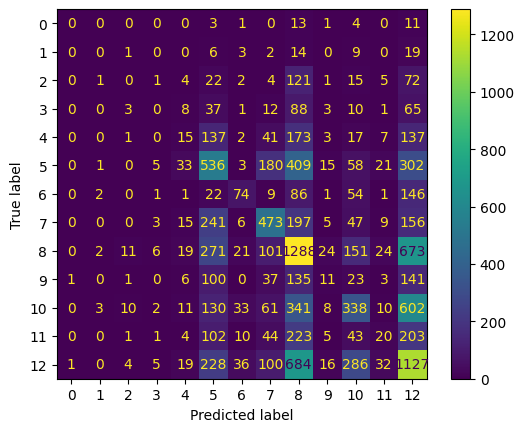

In [36]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [37]:
accuracy_score(y_test, prediction)

0.3235

In [38]:
f1_score(y_test, prediction, average='weighted')

0.2945879825567842